## 一、图片风格迁移 Neural Style Transfer 

[A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf)
本文介绍了Neural Style Transfor模型


[Demystifying Neural Style Transfer](https://arxiv.org/pdf/1701.01036.pdf)

In [25]:
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


读取两张图片

In [54]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)
    if max_size:
        scale = max_size / max(image.size)
        size= np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
         
    if shape:
        image = image.resize(shape, Image.LANCZOS)
        
    if transform:
        image = transform(image).unsqueeze(0)
        
    return image.to(device)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
]) # 来自ImageNet的mean和variance

content = load_image("../common/images/content.jpg",transform,max_size=400)
style = load_image("../common/images/style.jpg",
                   transform,shape=[content.size(2),content.size(3)])

In [55]:
content.shape

torch.Size([1, 3, 266, 400])

In [56]:
style.shape

torch.Size([1, 3, 400, 266])

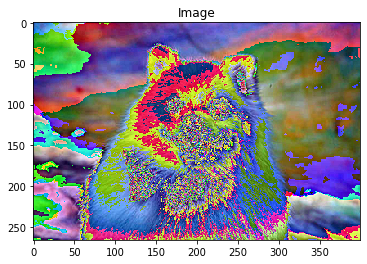

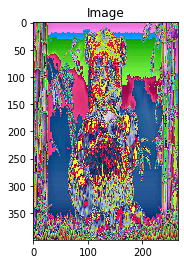

In [57]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
# 这些是normalize之后图片的样子
imshow(content[0], title='Image')
imshow(style[0], title='Image')

In [46]:
vgg19model = models.vgg19(pretrained=True)

In [14]:
vgg19model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# 定义一个迁移的VGGNet

In [47]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        # 去VGG19的['0', '5', '10', '19', '28']这些层
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

# 这个target是我们最终需要训练的结果
target = content.clone().requires_grad_(True)
# 我们最终要更新的是target的值
optimizer = torch.optim.Adam([target], lr=0.003, betas=[0.5, 0.999])
vgg = VGGNet().to(device).eval()

In [36]:
vgg

VGGNet(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [52]:
target_features = vgg(target)
target_features

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0334, 0.0311, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.8768, 0.8917,  ..., 1.0222, 1.0182, 1.9415],
           [0.0000, 0.2539, 0.2622,  ..., 0.3347, 0.3300, 1.8856],
           [0.0000, 0.2732, 0.2727,  ..., 0.3315, 0.3318, 1.9053],
           ...,
           [0.0000, 0.3047, 0.2991,  ..., 0.3103, 0.3017, 1.4002],
           [0.0000, 0.3336, 0.3507,  ..., 0.3040, 0.3003, 1.3824],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3525]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.00

# 模型开始训练

In [53]:
total_step = 2000
style_weight = 100.
for step in range(total_step):
    # 用VGG模型来encode：target，content，style三张图片
    target_features = vgg(target)
    content_features = vgg(content) 
    style_features = vgg(style)
    
    style_loss = 0 # 风格损失值
    content_loss = 0 # 内容损失值
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        # 计算content_loss:内容损失函数：
        # 目标图片和内容图片的encode的特征值的差的平方越小，我们则认为两张图片的内容越相似
        content_loss += torch.mean((f1-f2)**2)
        _, c, h, w = f1.size()
        f1 = f1.view(c, h*w)
        f3 = f3.view(c, h*w)
        
        # 计算gram matrix
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())
        # 计算风格损失值
        # 目标图片和风格图片的余弦相似度越大说明越像，所以余弦相似度的导数来做风格损失函数
        style_loss += torch.mean((f1-f3)**2)/(c*h*w)
        
    loss = content_loss + style_weight * style_loss
    
    # 更新target
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 10 == 0:
        print("Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}"
             .format(step, total_step, content_loss.item(), style_loss.item()))  

Step [0/2000], Content Loss: 0.0000, Style Loss: 77.5129


KeyboardInterrupt: 

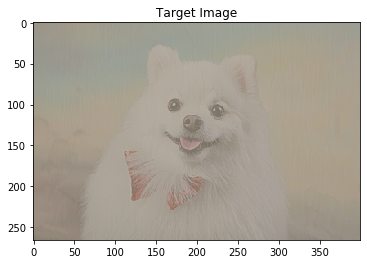

In [58]:
# 这里跑的不多，但是可以稍微看出一点效果
denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
img = target.clone().squeeze()
img = denorm(img).clamp_(0, 1)
plt.figure()
imshow(img, title='Target Image')

## Generative Adversarial Networks 生成对抗神经网络


In [80]:
batch_size=32
transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5),
#                         std=(0.5, 0.5, 0.5))
])

mnist_data = torchvision.datasets.MNIST("./mnist_data", train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=mnist_data,
                                         batch_size=batch_size,
                                         shuffle=True)

In [89]:
batch = next(iter(dataloader))
batch[0]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

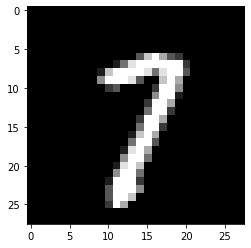

In [99]:
plt.imshow(batch[0][3][0],cmap=plt.cm.gray)

In [60]:
image_size = 784 # 28*28

hidden_size = 256
# discriminator :判别器
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

latent_size = 64 
# Generator :生成器
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

D = D.to(device)
G = G.to(device)

loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

total_step = len(dataloader)
num_epochs = 200
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        batch_size = images.size(0)
        images = images.reshape(batch_size, image_size).to(device)
        
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        outputs = D(images)
        d_loss_real = loss_fn(outputs, real_labels)
        real_score = outputs # 对于D来说越大越好
        
        # 开始生成fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach()) # 如果不detach()在反向传播的时候会把生成fake_images的gradient也进行计算
        d_loss_fake = loss_fn(outputs, fake_labels)
        fake_score = outputs # 对于D来说，这个分数越小越好
        
        # 开始优化discriminator
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 开始优化generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = loss_fn(outputs, real_labels)
        
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if i % 1000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}"
                 .format(epoch, num_epochs, i, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
        
        

## DCGAN

[UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS](https://arxiv.org/pdf/1511.06434.pdf)

[图片下载地址](https://drive.google.com/drive/folders/0B7EVK8r0v71pbWNEUjJKdDQ3dGc)
https://drive.google.com/drive/folders/0B7EVK8r0v71pbWNEUjJKdDQ3dGc

In [117]:
import torchvision.utils as vutils


In [118]:
ls ../common/images/transpose

11.jpg       12.jpg       13.jpg       14.jpg       content.jpg  style.jpg


In [121]:
image_size=64
batch_size=128
dataroot="../common/images/transpose"
num_workers = 2
dataset = torchvision.datasets.ImageFolder(root=dataroot, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


RuntimeError: Found 0 files in subfolders of: ./mnist_data
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif,.tiff,.webp